- ~~Your final result should overcome the F1=0.5. Any team with lower results is failed (all or nothing)~~
- ~~You must provide your working pipeline on the last day of submission. Please, make it look well~~
- ~~Base EDA and data preprocessing: (+3)~~

    ~~a. clarify the meaning of features you are going to exploit~~

   ~~b. Execute the correlation analysis of variables, try to establish dependent ones~~

  ~~c. Perform feature selection~~

  ~~d. Perform data preprocessing (encode your features in some way, different types of encoding may dramatically affect your model, be selective, try multiple (at leas 2) ways)~~

- ~~Try at least 3 different types of models (+2)~~
- ~~Try an ensemble model with trainable and non-trainable weights. (+2)~~
- ~~Make explainable model (+2)~~
- ~~Aggregate the results, proceed the error analysis, compare the models (+1)~~
- *Try to get the highest score (Top 1 +3; Top 2 +2; Top 3 +1)
- ~~*Try NN approach for the task (+1)~~
- *Make explainable model with top score (+2)

https://www.kaggle.com/competitions/dm2023-ml-course-lab-1-tabular/overview

# Import libraries

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Reading data

In [31]:
# Load data
data_test = pd.read_csv("./test.csv")
data_train = pd.read_csv("./train.csv")
# data_val = pd.read_csv("./data/TCGA_GBM_LGG_Mutations_all.csv")

# Basic data exploration
print("First few rows of the training data:")
print(data_train.head())
print("\nTraining data info:")
print(data_train.info())
print("\nTraining data description:")
print(data_train.describe())

# Print the length of data
# print(f"\nNumber of rows in validation data: {len(data_val)}")
print(f"Number of rows in training data: {len(data_train)}")
print(f"Number of rows in test data: {len(data_test)}")

First few rows of the training data:
   Unnamed: 0 Grade       Case_ID  Gender   Age_at_diagnosis  \
0           0   GBM  TCGA-06-A6S0    Male  79 years 183 days   
1           1   LGG  TCGA-HT-8106    Male  53 years 197 days   
2           2   LGG  TCGA-HT-7607  Female  61 years 305 days   
3           3   LGG  TCGA-QH-A6X5  Female   58 years 55 days   
4           4   LGG  TCGA-P5-A5F1    Male  30 years 113 days   

         Primary_Diagnosis                       Race         IDH1  \
0             Glioblastoma  black or african american  NOT_MUTATED   
1  Astrocytoma, anaplastic                      white      MUTATED   
2         Astrocytoma, NOS                      white      MUTATED   
3             Mixed glioma                      white      MUTATED   
4         Astrocytoma, NOS                      white      MUTATED   

          TP53         ATRX  ...        FUBP1          RB1       NOTCH1  \
0  NOT_MUTATED  NOT_MUTATED  ...  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
1      

# EDA and data preprocessing

In [32]:
# def get_val_target(data_val, data_test):
#     # Ensure no side-effects outside the function
#     data_val = data_val.copy().set_index('Case_ID')

#     try:
#         # Directly access the necessary rows and avoid using a for loop
#         val_data = pd.DataFrame(data_val.loc[data_test.index, 'Grade'], columns=['Target'])
#     except KeyError as e:
#         print(f"KeyError: {str(e)}")
#         print("Ensure that the indices from data_test are present in data_val.")
#         return None

#     # Mapping the target variable to binary and handling potential unexpected values
#     target_mapping = {'LGG': 1, 'GBM': 0}
#     val_data['Target'] = val_data['Target'].map(target_mapping)

#     # Check if any value was not mapped (is NaN)
#     if val_data['Target'].isna().any():
#         print("Warning: NaN values detected in target. Check your mapping and input data.")

#     return val_data

In [33]:
# data_copy = data_copy.drop(['Primary_Diagnosis'], axis = 1)
# print(data_copy)

In [34]:
def setting_columns(data):
    data_copy = data.copy()

    # Check if columns exist before trying to operate on them
    if 'Unnamed: 0' in data_copy.columns:
        data_copy = data_copy.drop(columns=['Unnamed: 0'])
    else:
        print("Warning: 'Unnamed: 0' not found in columns.")

    if 'Case_ID' in data_copy.columns:
        data_copy = data_copy.set_index('Case_ID')
    else:
        print("Warning: 'Case_ID' not found in columns.")

    return data_copy

def delete_null_rows(data):
    data_copy = data.copy()


    # Define columns to check for '--' value
    columns_to_check = ['Grade', 'Gender', 'Age_at_diagnosis', 'Race',
                        'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA',
                        'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3',
                        'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']

    # Use vectorized operations to filter rows
    filter_condition = (data_copy[columns_to_check] != '--').all(axis=1) & (data_copy['Race'] != 'not reported')
    data_copy = data_copy.loc[filter_condition]

    return data_copy

def coding_categorical_features(data):
    data_copy = data.copy()
    labelencoder = LabelEncoder()

    # Conditionally encode 'Grade' if it's present
    label_encode_cols = ['Gender'] + [
        'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA',
        'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4',
        'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA', 'Primary_Diagnosis'
    ]
    if 'Grade' in data_copy.columns:
        label_encode_cols.insert(0, 'Grade')

    one_hot_encode_cols = ['Race']
    for col in label_encode_cols:
        try:
            data_copy[col] = labelencoder.fit_transform(data_copy[col].astype(str))
        except Exception as e:
            print(f"An error occurred with column {col}: {str(e)}")
    data_copy = pd.get_dummies(data_copy, columns=one_hot_encode_cols, drop_first=True)
    return data_copy


# Modifying the function to extract only the years and handle different formats
def breakdown_into_age_groups(data, age_bins=None, labels=None):
    data_copy = data.copy()
    if age_bins is None:
        age_bins = [0, 18, 45, 60, 75, 91]
    if labels is None:
        labels = [0, 1, 3, 4, 5]

    # Extract age and handle possible exceptions
    try:
        data_copy['Age_at_diagnosis'] = data_copy['Age_at_diagnosis'].apply(
            lambda x: int(re.findall(r'\d+', str(x))[0]) if pd.notnull(x) else np.nan)
    except Exception as e:
        print(f"An error occurred: {str(e)}")

    # Apply binning
    data_copy['Age_at_diagnosis'] = pd.cut(data_copy['Age_at_diagnosis'], bins=age_bins, labels=labels, right=False)
    return data_copy

In [35]:
def preprocessing_data_train(data, age_bins=None, age_labels=None):
    data_processed = (
        data.pipe(setting_columns)
            .pipe(delete_null_rows)
            .pipe(coding_categorical_features)
            .pipe(breakdown_into_age_groups, age_bins=age_bins, labels=age_labels)
    )
    return data_processed


def preprocessing_data_test(data, age_bins=None, age_labels=None):
    data_processed = data.pipe(setting_columns)

    # Replace placeholder and unreported values with NaN
    columns_with_placeholders = ['Gender', 'Age_at_diagnosis', 'Race']
    data_processed[columns_with_placeholders] = (
        data_processed[columns_with_placeholders].replace(['--', 'not reported'], np.nan)
    )

    # Continue processing
    data_processed = (
        data_processed.pipe(coding_categorical_features)
                      .pipe(breakdown_into_age_groups, age_bins=age_bins, labels=age_labels)
    )
    return data_processed

In [36]:
# Applying the preprocessing functions
preprocessed_data_train = preprocessing_data_train(data_train)
preprocessed_data_test = preprocessing_data_test(data_test)

# Converting 'Age_at_diagnosis' to a numeric type before replacing NaN values
preprocessed_data_train['Age_at_diagnosis'] = pd.to_numeric(preprocessed_data_train['Age_at_diagnosis'], errors='coerce', downcast='integer')
preprocessed_data_test['Age_at_diagnosis'] = pd.to_numeric(preprocessed_data_test['Age_at_diagnosis'], errors='coerce', downcast='integer')

# Replacing NaN values in 'Age_at_diagnosis' with -1
preprocessed_data_train['Age_at_diagnosis'].fillna(0, inplace=True)
preprocessed_data_test['Age_at_diagnosis'].fillna(0, inplace=True)

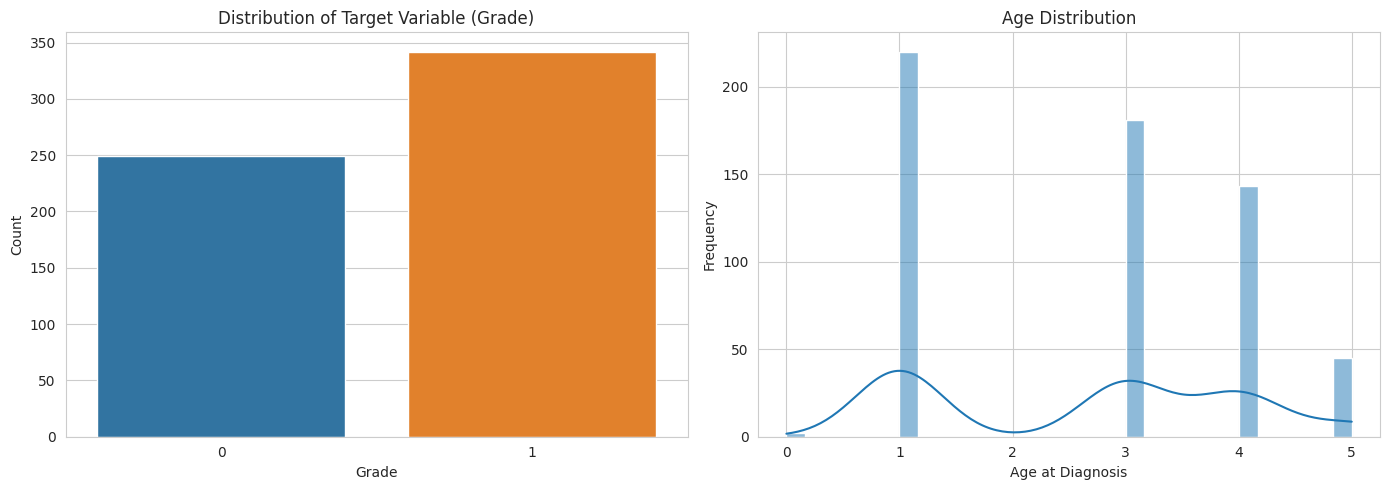

In [37]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 1. Distribution of Target Variable (Grade)
sns.countplot(x='Grade', data=preprocessed_data_train, ax=ax[0])
ax[0].set_title('Distribution of Target Variable (Grade)')
ax[0].set_xlabel('Grade')
ax[0].set_ylabel('Count')

# 2. Age Distribution
sns.histplot(preprocessed_data_train['Age_at_diagnosis'], bins=30, ax=ax[1], kde=True)
ax[1].set_title('Age Distribution')
ax[1].set_xlabel('Age at Diagnosis')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [38]:
proportion_of_mutated_genes = []
columns_dna = ['IDH1', 'TP53', 'ATRX', 'PTEN',
               'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1',
               'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4',
               'PDGFRA']
data_copy = preprocessed_data_train[columns_dna]

for i, row in data_copy.iterrows():
    proportion_of_mutated_genes.append(sum(row)/20)

preprocessed_data_train['proportion_of_mutated_genes'] = proportion_of_mutated_genes
preprocessed_data_train['IDH_mutation'] = preprocessed_data_train['IDH1'] + preprocessed_data_train['IDH2']

In [39]:
preprocessed_data_train_with_pd = preprocessed_data_train
preprocessed_data_train = preprocessed_data_train.drop(columns=['Primary_Diagnosis'], axis=1)

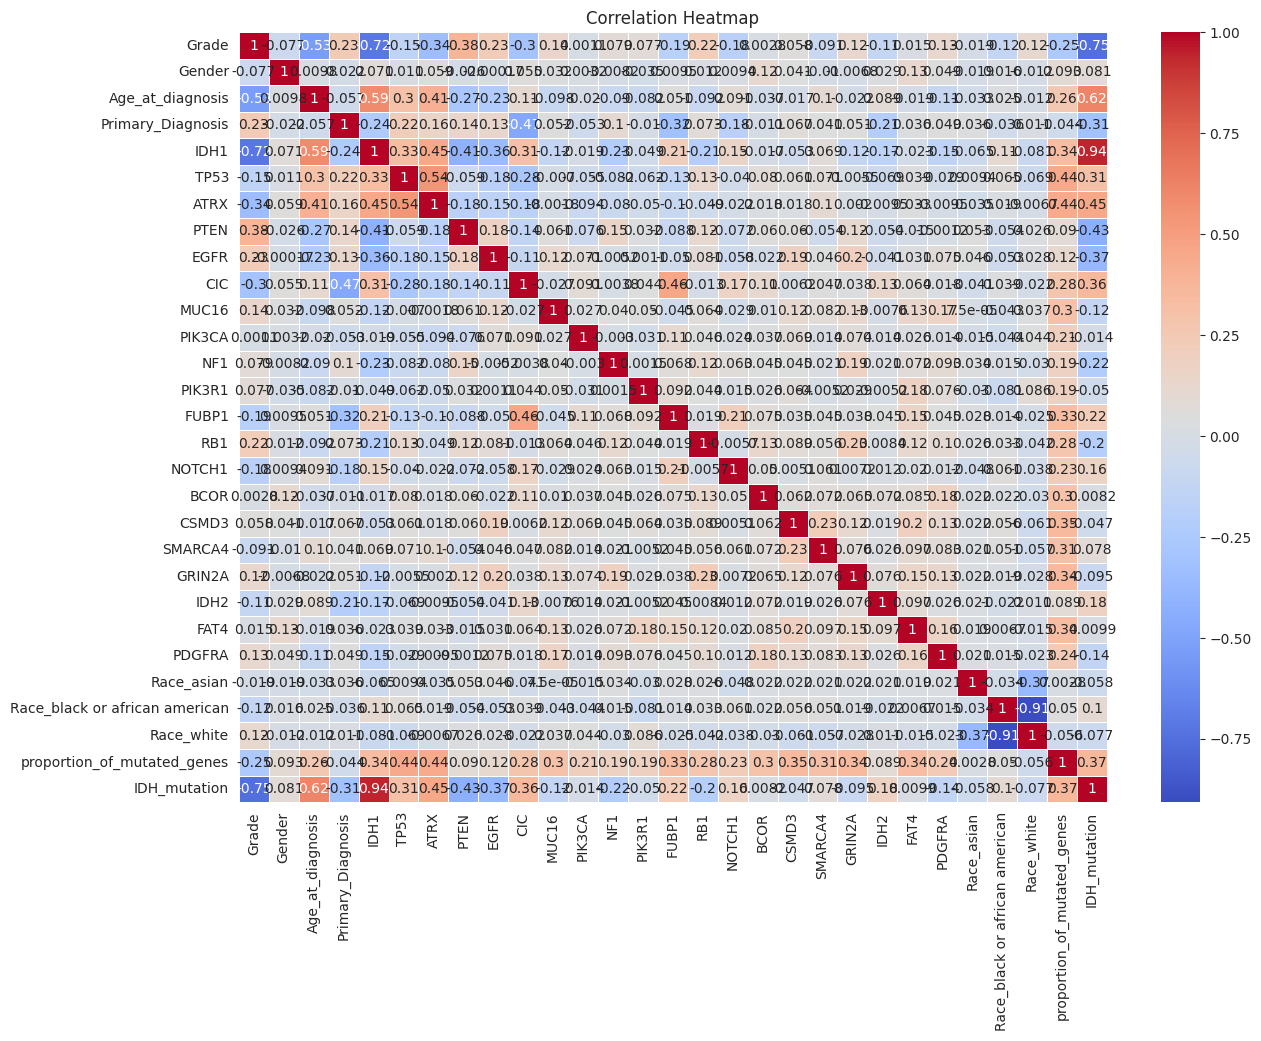

In [40]:
# 3. Correlation Heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = preprocessed_data_train_with_pd.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

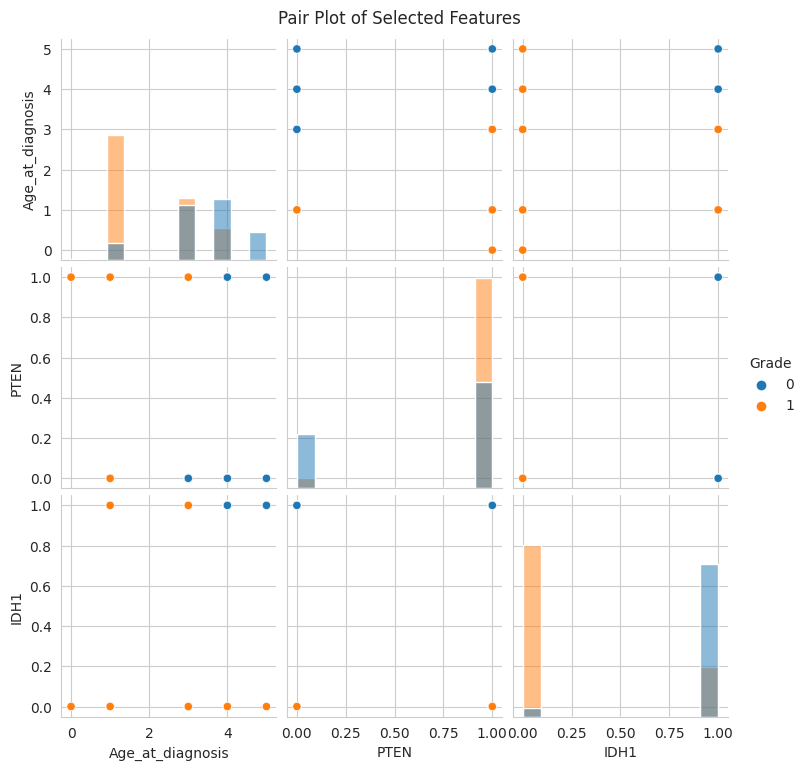

In [41]:
#4. Pair Plot (for a subset of features)
# Selecting a subset of features including the target

selected_features = ['Grade', 'Age_at_diagnosis', 'PTEN', 'IDH1']  # Replace with desired feature names

# Creating the pair plot
sns.pairplot(preprocessed_data_train[selected_features], hue='Grade', kind='scatter', diag_kind='hist')
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

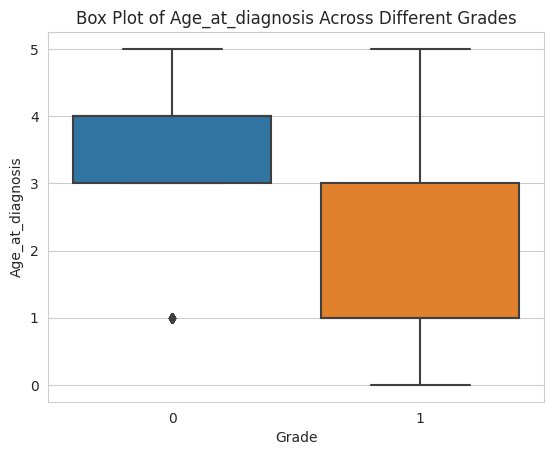

In [42]:
#5. Box Plots (for numerical features across different target classes)
# Selecting a numerical feature
numerical_feature = 'Age_at_diagnosis'  # Replace with desired feature name

# Creating the box plot
sns.boxplot(x='Grade', y=numerical_feature, data=preprocessed_data_train)
plt.title(f'Box Plot of {numerical_feature} Across Different Grades')
plt.show()


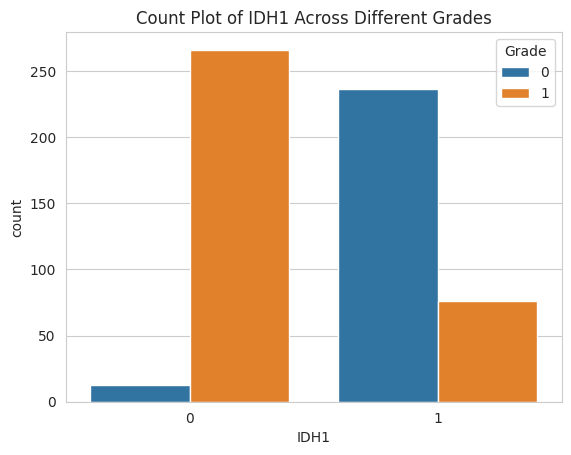

In [43]:
#6. Count Plots (for categorical features)
# Selecting a categorical feature
categorical_feature = 'IDH1'  # Replace with desired feature name

# Creating the count plot
sns.countplot(x=categorical_feature, hue='Grade', data=preprocessed_data_train)
plt.title(f'Count Plot of {categorical_feature} Across Different Grades')
plt.show()


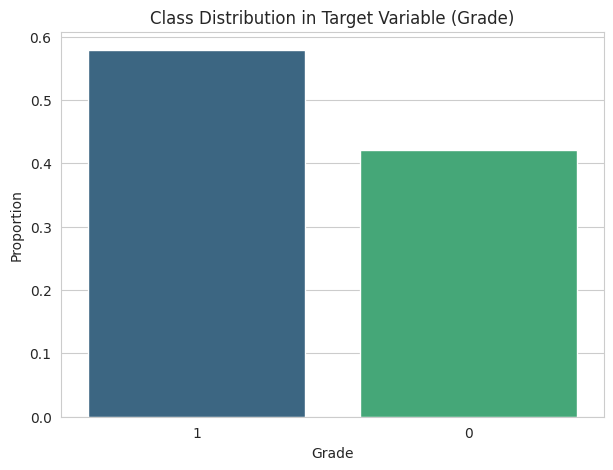

,Grade,Proportion
0,1,0.57868
1,0,0.42132


In [44]:
# Checking the class distribution in the target variable 'Grade'
class_distribution = preprocessed_data_train['Grade'].value_counts(normalize=True).reset_index()
class_distribution.columns = ['Grade', 'Proportion']
class_distribution['Grade'] = class_distribution['Grade'].astype(str)  # Converting to string for better readability

# Visualizing the class distribution
plt.figure(figsize=(7, 5))
sns.barplot(x='Grade', y='Proportion', data=class_distribution, palette='viridis')
plt.title('Class Distribution in Target Variable (Grade)')
plt.ylabel('Proportion')
plt.xlabel('Grade')
plt.show()

# Displaying the exact class distribution
class_distribution

## Feature selection

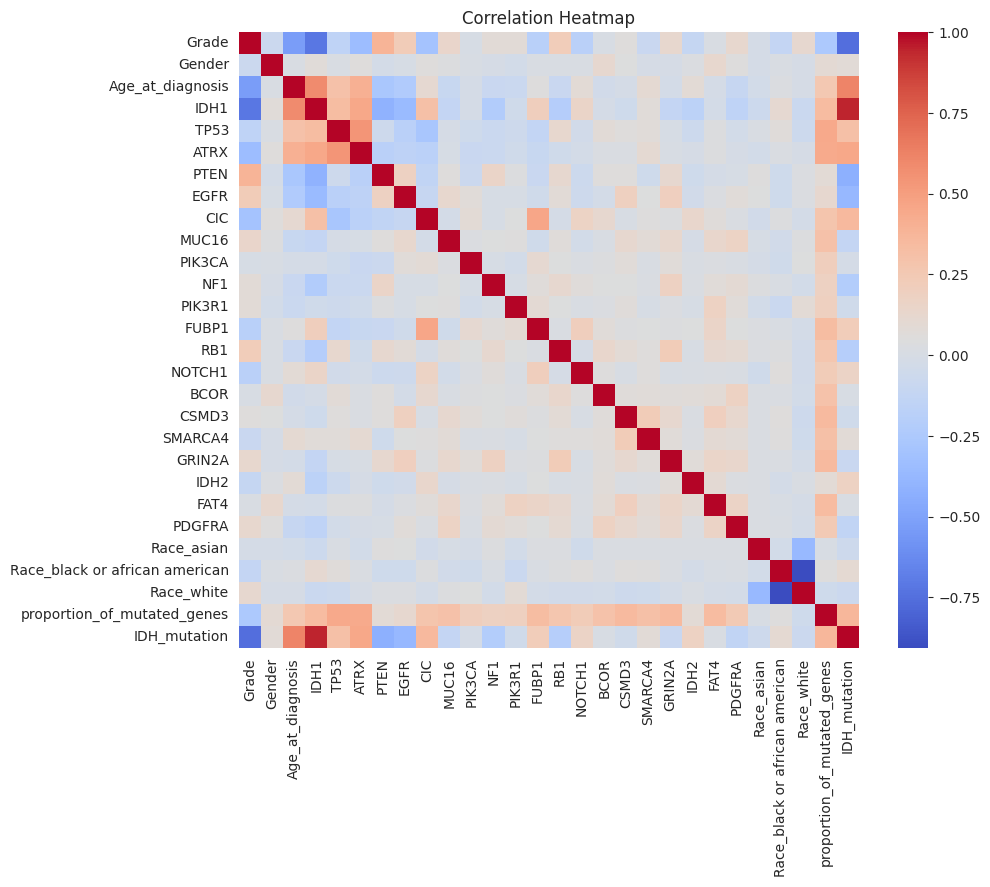

                             Importances
Features                                
IDH_mutation                    0.263190
IDH1                            0.179552
Age_at_diagnosis                0.129477
proportion_of_mutated_genes     0.064020
PTEN                            0.051407
ATRX                            0.037811
Gender                          0.031798
EGFR                            0.025537
CIC                             0.022977
NF1                             0.021408


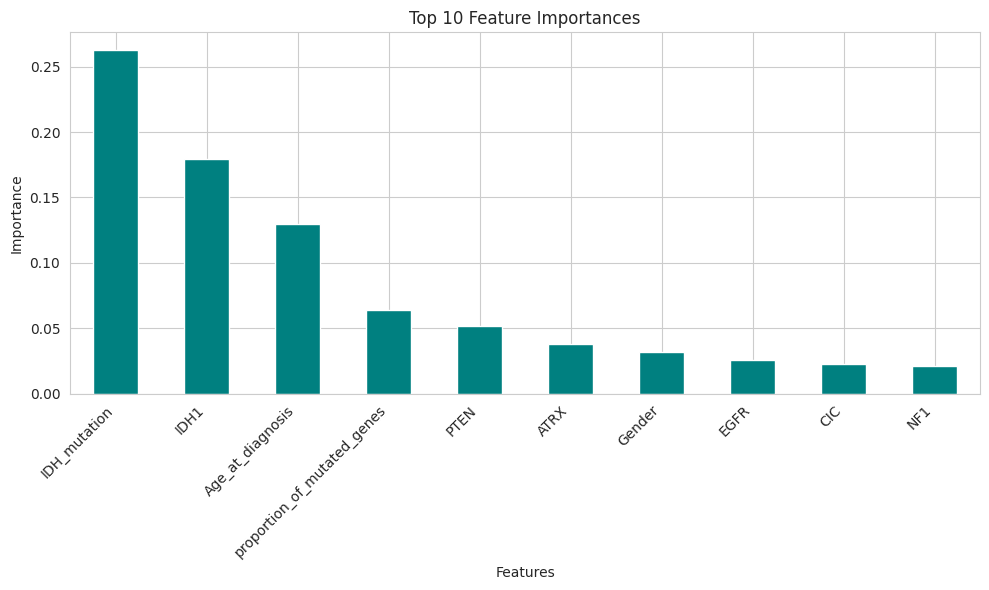

In [45]:
from sklearn.ensemble import RandomForestClassifier
# Separate target and features
data_train_target = preprocessed_data_train['Grade']
data_train_features = preprocessed_data_train.drop(columns=['Grade'], axis=1)

# Compute and display the correlation matrix with a heatmap
corr = preprocessed_data_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False)  # Using a heatmap for better visualization
plt.title("Correlation Heatmap")
plt.show()

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=340, random_state=42)
model.fit(preprocessed_data_train.drop(columns=['Grade']), preprocessed_data_train['Grade'])

# Get and sort feature importances
importances = model.feature_importances_
final_df = pd.DataFrame({"Features": preprocessed_data_train.drop(columns=['Grade']).columns,
                         "Importances": importances})
final_df = final_df.set_index('Features').sort_values('Importances', ascending=False)

# Display and visualize the feature importances
print(final_df.head(10))

# Visualization
plt.figure(figsize=(10, 6))
final_df.head(10).plot.bar(color='teal', legend=False, ax=plt.gca())
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

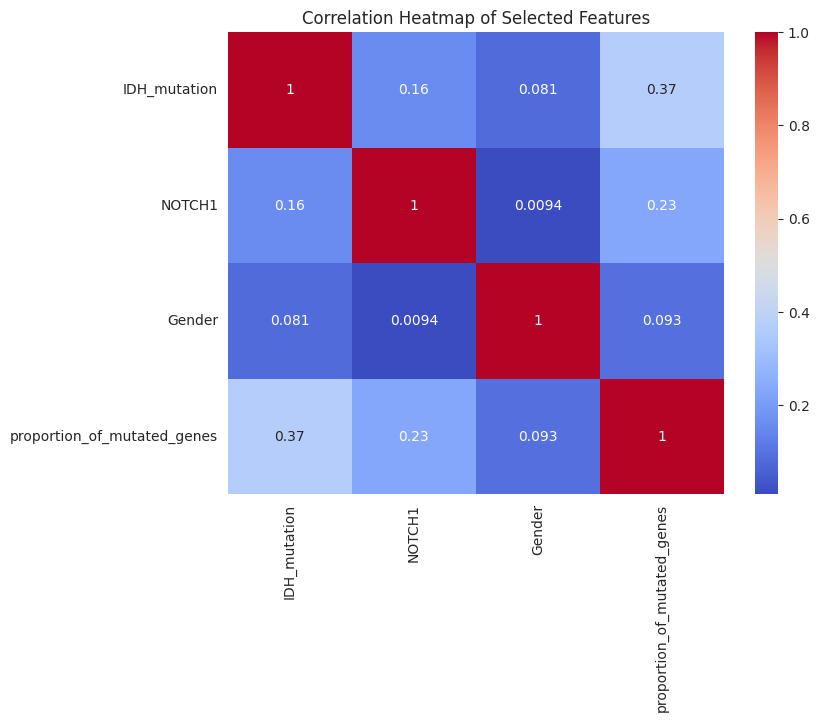

In [104]:
# # Redefining the function to obtain validation target
# def get_val_target(data_val, data_test):
#     # Setting the index to facilitate easy retrieval of target values
#     data_val = data_val.set_index('Case_ID')

#     # Extracting the 'Grade' column for the test indices and mapping it to binary classification
#     val_data = data_val.loc[data_test.index, 'Grade'].map({'LGG': 1, 'GBM': 0}).reset_index(drop=True)

#     return val_data

# Re-running the pipeline code block with the function defined

# Selected features based on Random Forest's feature importances
# selected_features = ['Age_at_diagnosis', 'proportion_of_mutated_genes', 'Gender', 'IDH1','PTEN', 'ATRX', 'CIC', 'IDH2', 'EGFR', 'TP53' ]
selected_features = ['IDH_mutation', 'NOTCH1', 'Gender', 'proportion_of_mutated_genes']

# Extract selected features from preprocessed training data for modeling
data_train_selected_features = preprocessed_data_train[selected_features]

# Correlation analysis of selected features
selected_corr = data_train_selected_features.corr()

# Visualize the correlation matrix of selected features using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(selected_corr, cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

# # Prepare validation features and target (ensure to use preprocessed data and handle missing values if necessary)
# X_val = preprocessed_data_test[selected_features].fillna(0)
# y_val = get_val_target(data_val, preprocessed_data_test)

# Models

## 3 different types of models

In [105]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [106]:
parameters_for_LinearSVC = {
    "penalty": ['l1', 'l2'],
    "loss": ['hinge', 'squared_hinge'],
    "max_iter": [1000, 1500, 2000, 2500],
    'C':[1, 10],
    'random_state': [5, 10, 42, 150],
    'class_weight': ["balanced", None],
    }

parameters_for_KNeighborsClassifier = {
    "n_neighbors": [x for x in range(5, 20, 5)],
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[x for x in (range(15,60,15))],
    'p': [1,2],
    }


In [107]:
# Use selected features for model training and evaluation
X = preprocessed_data_train[selected_features]
y = preprocessed_data_train['Grade']


# print(X.columns)
# print(y)

# Split data into training and testing sets, ensuring balanced class distribution in splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize score storage
f1_scores_test = {}
# f1_scores_val = {}


model_svc = GridSearchCV(LinearSVC(), param_grid = parameters_for_LinearSVC, scoring = 'f1')
model_svc.fit(X_train, y_train)
f1_scores_test["Support Vector Machines"] = f1_score(y_test, model_svc.predict(X_test), average='binary')

model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
f1_scores_test["Naive Bayes"] = f1_score(y_test, model_nb.predict(X_test), average='binary')

model_kn = GridSearchCV(KNeighborsClassifier(), param_grid = parameters_for_KNeighborsClassifier, scoring = 'f1')
model_kn.fit(X_train, y_train)
f1_scores_test["KNeighborsClassifier"] = f1_score(y_test, model_kn.predict(X_test), average='binary')


# # Display F1 Scores
print("F1 Scores on Test Data: ", f1_scores_test)
# # print("F1 Scores on Validation Data: ", f1_scores_val)


F1 Scores on Test Data:  {'Support Vector Machines': 0.8730158730158731, 'Naive Bayes': 0.05633802816901409, 'KNeighborsClassifier': 0.864}


In [108]:
print("F1 Scores on Test Data: ", f1_scores_test)

F1 Scores on Test Data:  {'Support Vector Machines': 0.8730158730158731, 'Naive Bayes': 0.05633802816901409, 'KNeighborsClassifier': 0.864}


<Figure size 800x600 with 0 Axes>

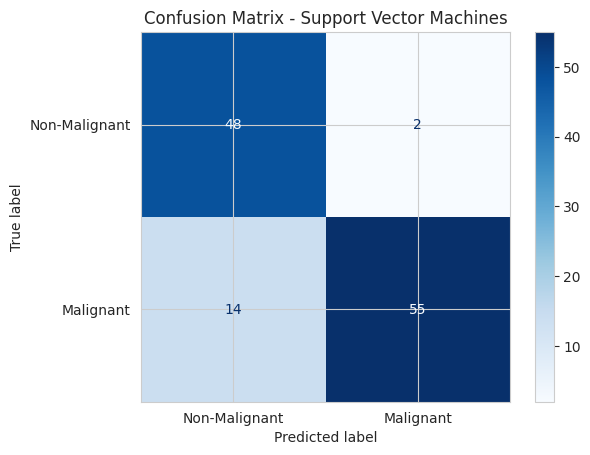

In [109]:
# Model to investigate: Support Vector Machines
model_ = model_svc

# Predictions on test data
predictions_test_ = model_.predict(X_test)

# Confusion Matrix
conf_mat_ = confusion_matrix(y_test, predictions_test_)

# Displaying the Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_mat_, display_labels=['Non-Malignant', 'Malignant']).plot(cmap='Blues', values_format=".0f")
plt.title("Confusion Matrix - Support Vector Machines")
plt.show()

# # Predictions on validation data
# predictions_val_svm = model_svm.predict(X_val)

# # Confusion Matrix for validation data
# conf_mat_val_svm = confusion_matrix(y_val, predictions_val_svm)

# # Displaying the Confusion Matrix for validation data
# plt.figure(figsize=(8, 6))
# ConfusionMatrixDisplay(conf_mat_val_svm, display_labels=['Non-Malignant', 'Malignant']).plot(cmap='Blues', values_format=".0f")
# plt.title("Confusion Matrix (Validation Data) - Support Vector Machines")
# plt.show()

<Figure size 800x600 with 0 Axes>

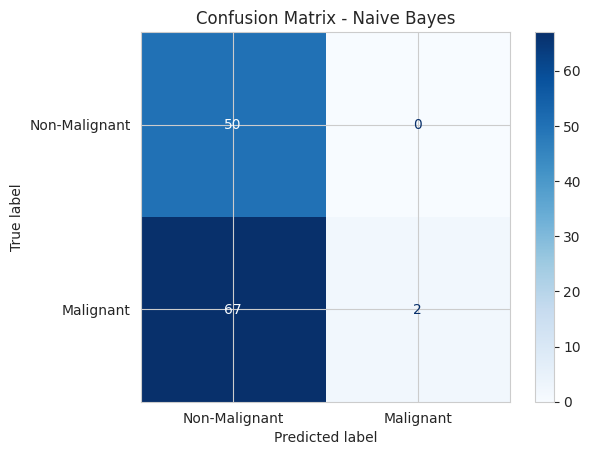

In [110]:
model_ = model_nb

# Predictions on test data
predictions_test_ = model_.predict(X_test)

# Confusion Matrix
conf_mat_ = confusion_matrix(y_test, predictions_test_)

# Displaying the Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_mat_, display_labels=['Non-Malignant', 'Malignant']).plot(cmap='Blues', values_format=".0f")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

<Figure size 800x600 with 0 Axes>

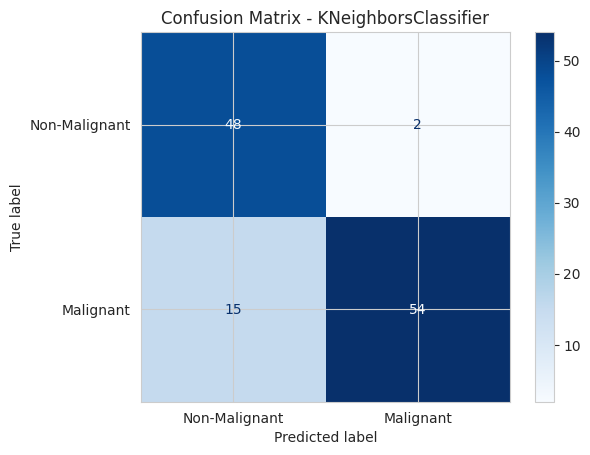

In [111]:
model_ = model_kn

# Predictions on test data
predictions_test_ = model_.predict(X_test)

# Confusion Matrix
conf_mat_ = confusion_matrix(y_test, predictions_test_)

# Displaying the Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_mat_, display_labels=['Non-Malignant', 'Malignant']).plot(cmap='Blues', values_format=".0f")
plt.title("Confusion Matrix - KNeighborsClassifier")
plt.show()

<Figure size 800x600 with 0 Axes>

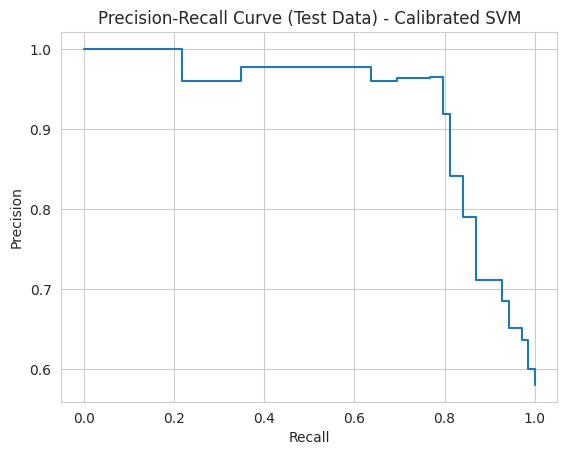

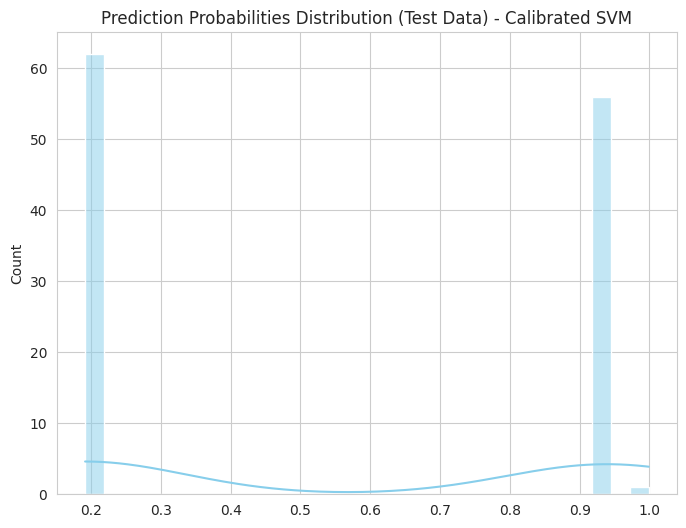

In [112]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Calibrate the SVM model using Platt scaling
calibrated_svm = CalibratedClassifierCV(model_svc, method='sigmoid', cv='prefit')
calibrated_svm.fit(X_train, y_train)

# Obtain calibrated prediction probabilities on test data
probabilities_test_svm = calibrated_svm.predict_proba(X_test)[:, 1]

# # Obtain calibrated prediction probabilities on validation data
# probabilities_val_svm = calibrated_svm.predict_proba(X_val)[:, 1]

# Precision-Recall Curve for test data
precision_test, recall_test, _ = precision_recall_curve(y_test, probabilities_test_svm)
plt.figure(figsize=(8, 6))
PrecisionRecallDisplay(precision=precision_test, recall=recall_test).plot()
plt.title("Precision-Recall Curve (Test Data) - Calibrated SVM")
plt.grid(True)
plt.show()

# Histogram of prediction probabilities for test data
plt.figure(figsize=(8, 6))
sns.histplot(probabilities_test_svm, bins=30, kde=True, color="skyblue")
plt.title("Prediction Probabilities Distribution (Test Data) - Calibrated SVM")
plt.grid(True)
plt.show()

# # Precision-Recall Curve for validation data
# precision_val, recall_val, _ = precision_recall_curve(y_val, probabilities_val_svm)
# plt.figure(figsize=(8, 6))
# PrecisionRecallDisplay(precision=precision_val, recall=recall_val).plot()
# plt.title("Precision-Recall Curve (Validation Data) - Calibrated SVM")
# plt.grid(True)
# plt.show()

# # Histogram of prediction probabilities for validation data
# plt.figure(figsize=(8, 6))
# sns.histplot(probabilities_val_svm, bins=30, kde=True, color="skyblue")
# plt.title("Prediction Probabilities Distribution (Validation Data) - Calibrated SVM")
# plt.grid(True)
# plt.show()

<Figure size 800x600 with 0 Axes>

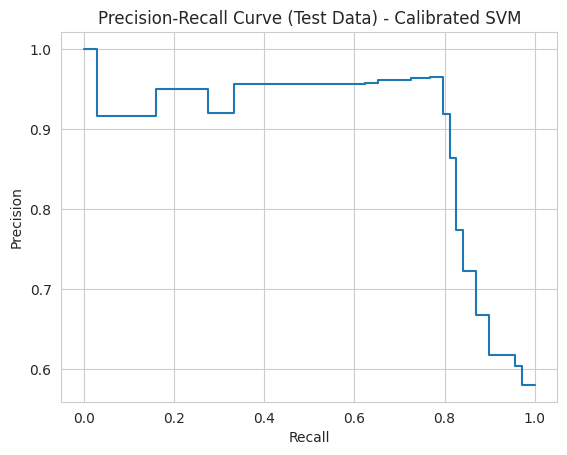

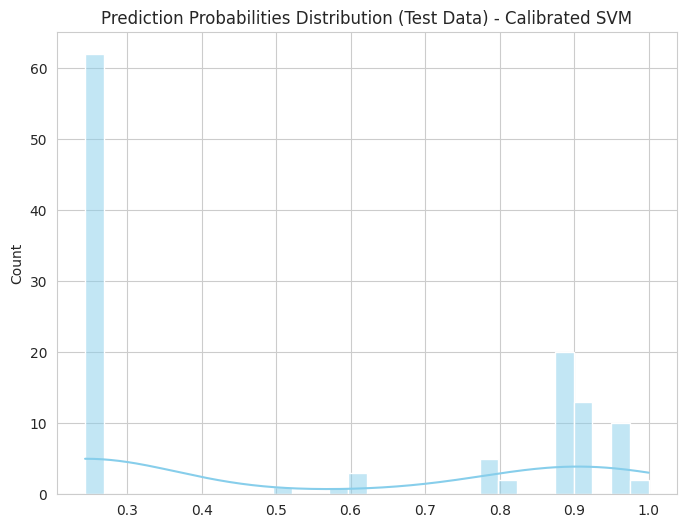

In [113]:
# Calibrate the NB model using Platt scaling
calibrated_ = CalibratedClassifierCV(model_nb, method='sigmoid', cv='prefit')
calibrated_.fit(X_train, y_train)

# Obtain calibrated prediction probabilities on test data
probabilities_test_ = calibrated_.predict_proba(X_test)[:, 1]

# # Obtain calibrated prediction probabilities on validation data
# probabilities_val_svm = calibrated_svm.predict_proba(X_val)[:, 1]

# Precision-Recall Curve for test data
precision_test, recall_test, _ = precision_recall_curve(y_test, probabilities_test_)
plt.figure(figsize=(8, 6))
PrecisionRecallDisplay(precision=precision_test, recall=recall_test).plot()
plt.title("Precision-Recall Curve (Test Data) - Calibrated SVM")
plt.grid(True)
plt.show()

# Histogram of prediction probabilities for test data
plt.figure(figsize=(8, 6))
sns.histplot(probabilities_test_, bins=30, kde=True, color="skyblue")
plt.title("Prediction Probabilities Distribution (Test Data) - Calibrated SVM")
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

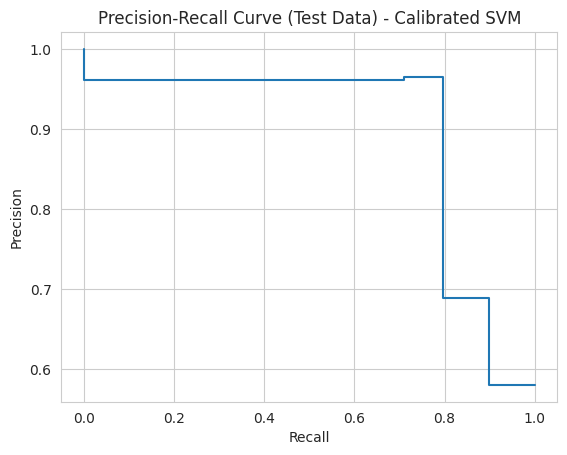

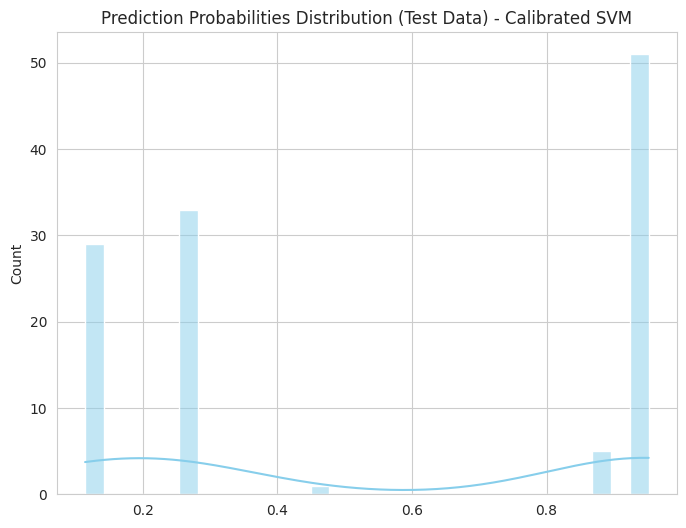

In [114]:
# Calibrate the KN model using Platt scaling
calibrated_ = CalibratedClassifierCV(model_kn, method='sigmoid', cv='prefit')
calibrated_.fit(X_train, y_train)

# Obtain calibrated prediction probabilities on test data
probabilities_test_ = calibrated_.predict_proba(X_test)[:, 1]

# # Obtain calibrated prediction probabilities on validation data
# probabilities_val_svm = calibrated_svm.predict_proba(X_val)[:, 1]

# Precision-Recall Curve for test data
precision_test, recall_test, _ = precision_recall_curve(y_test, probabilities_test_)
plt.figure(figsize=(8, 6))
PrecisionRecallDisplay(precision=precision_test, recall=recall_test).plot()
plt.title("Precision-Recall Curve (Test Data) - Calibrated SVM")
plt.grid(True)
plt.show()

# Histogram of prediction probabilities for test data
plt.figure(figsize=(8, 6))
sns.histplot(probabilities_test_, bins=30, kde=True, color="skyblue")
plt.title("Prediction Probabilities Distribution (Test Data) - Calibrated SVM")
plt.grid(True)
plt.show()

In [115]:
# !pip install shap

In [116]:
model_svc

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [1, 10], 'class_weight': ['balanced', None],
                         'loss': ['hinge', 'squared_hinge'],
                         'max_iter': [1000, 1500, 2000, 2500],
                         'penalty': ['l1', 'l2'],
                         'random_state': [5, 10, 42, 150]},
             scoring='f1')

In [117]:
# import shap

# # Initialize JavaScript for SHAP plots
# shap.initjs()

# # Create a SHAP explainer object
# explainer = shap.Explainer(model_nb, X_train)

# # Compute SHAP values for a sample of the data
# # (using a sample for computational efficiency)
# shap_values_sample = explainer.shap_values(X_test.sample(100, random_state=42))

# # Visualize SHAP values for a single prediction
# shap.force_plot(explainer.expected_value, shap_values_sample[0], X_test.iloc[0, :])

In [118]:
'''
Base Value: This is the average prediction of the model across all instances and is represented as the starting point of the plot.

Output Value: This is the model's prediction for this specific instance.

Red vs. Blue: Features pushing the prediction higher are shown in red, while features pushing the prediction lower are in blue.

Feature Importance: The x-axis shows the SHAP value, which is a measure of the impact of each feature on the prediction. Larger SHAP values (further from the base value) indicate features that are more important for a particular prediction.

Example Interpretation
Red Dots/Arrows: Each red dot or arrow indicates a feature that is pushing the model's prediction higher than the base value. The further to the right the dot is, the larger its impact.

Blue Dots/Arrows: Conversely, blue dots or arrows indicate features that are pushing the prediction lower than the base value. The further to the left, the larger its impact.

Position of Dots: The horizontal position of the dot represents the magnitude of the SHAP value, which directly relates to how much that feature is influencing the model to increase or decrease its prediction.
'''

"\nBase Value: This is the average prediction of the model across all instances and is represented as the starting point of the plot.\n\nOutput Value: This is the model's prediction for this specific instance.\n\nRed vs. Blue: Features pushing the prediction higher are shown in red, while features pushing the prediction lower are in blue.\n\nFeature Importance: The x-axis shows the SHAP value, which is a measure of the impact of each feature on the prediction. Larger SHAP values (further from the base value) indicate features that are more important for a particular prediction.\n\nExample Interpretation\nRed Dots/Arrows: Each red dot or arrow indicates a feature that is pushing the model's prediction higher than the base value. The further to the right the dot is, the larger its impact.\n\nBlue Dots/Arrows: Conversely, blue dots or arrows indicate features that are pushing the prediction lower than the base value. The further to the left, the larger its impact.\n\nPosition of Dots: The

# Ensemble models

## an ensemble model with trainable weights

In [119]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [120]:
param_grid = {
    'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 30],
    'learning_rate': [(0.001 + x / 100) for x in range(0, 10)],
    'algorithm': ['SAMME', 'SAMME.R'],
    'random_state': [x for x in range(0,100,5)]
}

model_adaboost = GridSearchCV(AdaBoostClassifier(), param_grid, scoring = 'f1')
model_adaboost.fit(X_train, y_train)

f1_score(y_test, model_adaboost.predict(X_test), average='binary')

0.8730158730158731

In [121]:
X_train

,IDH_mutation,NOTCH1,Gender,proportion_of_mutated_genes
Case_ID,,,,
TCGA-14-3476,2,1,1,0.90
TCGA-E1-5307,1,1,0,0.85
TCGA-HT-7480,1,1,1,0.90
TCGA-WY-A859,1,1,0,0.85
TCGA-12-0616,2,1,0,0.95
...,...,...,...,...
TCGA-14-1453,2,1,1,0.90
TCGA-28-2513,2,1,0,0.85
TCGA-76-6660,2,1,1,0.85


In [122]:
model_xgbc = XGBClassifier()
model_xgbc.fit(X_train,y_train)
f1_score(y_test, model_xgbc.predict(X_test), average='binary')


0.864

In [123]:
# from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

# # Function to train and evaluate a model
# def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, f1_scores_test):
#     model.fit(X_train, y_train)
#     f1_scores_test[model_name] = f1_score(y_test, model.predict(X_test), average='binary')
#     return model, f1_scores_test

# # Initialize models
# models_to_train = {
#     'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100, random_state=0),
#     'RandomForest Classifier': RandomForestClassifier(n_estimators=100),
#     'Logistic Regression': LogisticRegression()
# }

# # Initialize score storage
# f1_scores_test = {}

# # Train, predict, and evaluate models
# for model_name, model_instance in models_to_train.items():
#     model_instance, f1_scores_test = train_and_evaluate_model(
#         model_instance, model_name,
#         X_train, y_train, X_test, y_test,
#         f1_scores_test
#     )

# # Convert scores to DataFrames for better visualization
# f1_scores_test_df = pd.DataFrame.from_dict(f1_scores_test, orient='index', columns=['F1'])

# # Visualize F1 Scores
# plt.figure(figsize=(10, 6))
# sns.barplot(x=f1_scores_test_df.index, y=f1_scores_test_df['F1'], palette="viridis")
# plt.ylabel('F1 Score')
# plt.title('F1 Score of Different Models on Test Data')
# plt.xticks(rotation=45)
# plt.ylim([0, 1])

# f1_scores_test_df

## an ensemble model with non - trainable weights

In [124]:
param_grid = {
    'n_estimators': [200, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],

}

model_rf = GridSearchCV(RandomForestClassifier(), param_grid, scoring = 'f1')
model_rf.fit(X_train, y_train)

f1_score(y_test, model_rf.predict(X_test), average='binary')

0.8730158730158731

In [ ]:
def save_result(predict):
    result = pd.DataFrame(predicts, columns=["GRADE"])
    result = result['GRADE'].replace([1,0], [0,1])
    result.to_csv('submission_adaboost.csv')


predicts = model_final.predict(X_val)
save_result(predicts)

NameError: name 'model_final' is not defined

## explainable model

In [125]:
param_grid = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'C': [1, 2, 3],
    'class_weight' : [None, 'balanced'],
    'random_state' :[0, 5, 42],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter' : [x for x in range(100,500, 50)]
}

model_lr = GridSearchCV(LogisticRegression(), param_grid, scoring = 'f1')
model_lr.fit(X_train, y_train)

f1_score(y_test, model_lr.predict(X_test), average='binary')

0.8730158730158731

## NN approach for the task

In [126]:
for col in X_train.columns:
    X_train[col] =  X_train[col].replace([True, False], [1,0])

Epoch 1/100
15/15 [==============================] - 1s 5ms/step - loss: 0.6456 - f1_score: 0.7570
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5088 - f1_score: 0.8501
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.4182 - f1_score: 0.8710
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3797 - f1_score: 0.8859
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3738 - f1_score: 0.8813
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3727 - f1_score: 0.8804
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3493 - f1_score: 0.8916
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3799 - f1_score: 0.8737
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3628 - f1_score: 0.8817
Epoch 10/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3595 - f1_score: 0.8777
Epoch 11/

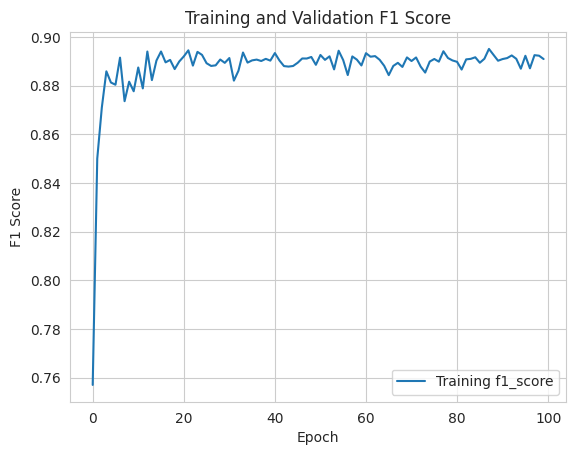

In [127]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Initialize Model
model = Sequential([
    Dense(512, activation='relu', input_dim=len(X_train.columns)),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(512, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score])

# # Early stopping
# early_stopping = EarlyStopping(monitor='val_f1_score', patience=10, restore_best_weights=True)

# Train Model
hist = model.fit(X_train, y_train,
                 epochs=100,  # Increasing epochs since we have early stopping
                 )  # Adding early stopping callback

# Visualization
plt.plot(hist.history['f1_score'], '-', label='Training f1_score')
# plt.plot(hist.history['val_f1_score'], ':', label='Validation f1_score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.show()

## Немного другая версия

In [128]:
import tensorflow as tf
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Dense(units=32, activation='relu', input_shape=(len(X_train.columns),)),  # We have 4 selected features
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Use selected features for model training and evaluation
X_train = preprocessed_data_train[selected_features]
y_train = preprocessed_data_train['Grade']

for col in X_train.columns:
    X_train[col] =  X_train[col].replace([True, False], [1,0])
for col in X_test.columns:
    X_test[col] =  X_test[col].replace([True, False], [1,0])


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=32, verbose=1
)

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
# val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print(train_acc)
print()
# print(val_acc)

Epoch 1/100
19/19 [==============================] - 1s 10ms/step - loss: 0.6921 - accuracy: 0.4602 - val_loss: 0.6817 - val_accuracy: 0.3697
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.6937 - val_loss: 0.6656 - val_accuracy: 0.8151
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.8680 - val_loss: 0.6470 - val_accuracy: 0.8571
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.8731 - val_loss: 0.6197 - val_accuracy: 0.8571
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.8731 - val_loss: 0.5858 - val_accuracy: 0.8571
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5682 - accuracy: 0.8731 - val_loss: 0.5512 - val_accuracy: 0.8571
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5296 - accuracy: 0.8731 - val_loss: 0.5160 - val_accuracy: 0.8571
Epoch 8/100
